In [1]:
## If you do not have the necessary libraries installed, run this cell (only for once)
# Be patient! It takes a few minutes.
## If you are running this notebook locally, to install standard libraries such as numpy, scipy, scikit-learn
# I recommend to use the package manager "conda". e.g.,  "conda install scikit-learn"
#!pip install ripser umap-learn kmapper persim PersistenceImages
#!pip install git+https://github.com/shizuo-kaji/CubicalRipser_3dim
#!pip install tomaster Boruta

In [2]:
import numpy as np
from dipy.core.gradients import gradient_table
from dipy.data import get_fnames, default_sphere, get_sphere
from dipy.io.gradients import read_bvals_bvecs
from dipy.io.image import load_nifti
from dipy.reconst.shm import CsaOdfModel
from dipy.direction import peaks_from_model
from dipy.segment.mask import median_otsu
import dipy.reconst.dti as dti
from bids.layout import BIDSLayout
import nibabel as nib
from scipy import ndimage  # To rotate image for visualization purposes
from dipy.io.image import load_nifti_data, load_nifti, save_nifti
import scipy as sp
import pandas as pd
import glob,os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ripser import ripser
import persim
import gudhi
from skimage.filters import threshold_otsu
from scipy.ndimage import distance_transform_edt
import cripser
import cv2


In [3]:
radient_layout = BIDSLayout("./openneuro/ds001907/sub-RC4201/ses-1/", validate=False)

subj = 'RC4201'

dwi_fname = radient_layout.get(subject=subj, suffix='dwi', extension='.nii.gz', return_type='file')[0]
bvec_fname = radient_layout.get( extension='.bvec', return_type='file')[0]
bval_fname = radient_layout.get( extension='.bval', return_type='file')[0]

dwi_img = nib.load(dwi_fname)
affine = dwi_img.affine

bvals, bvecs = read_bvals_bvecs(bval_fname, bvec_fname)
gtab = gradient_table(bvals, bvecs)
t1_fname = './openneuro/ds001907/sub-RC4201/ses-1/anat/sub-RC4201_ses-1_T1w.nii.gz'
t1_data = load_nifti_data(t1_fname)
dwi_data = dwi_img.get_fdata()
maskdata, mask = median_otsu(dwi_data, vol_idx=range(10, 50), median_radius=3,
                             numpass=1, autocrop=True, dilate=2)
print('maskdata.shape (%d, %d, %d, %d)' % maskdata.shape)
print('data.shape (%d, %d, %d, %d)' % dwi_data.shape)
csamodel = CsaOdfModel(gtab, 4)
sphere = get_sphere('repulsion724')
csapeaks = peaks_from_model(model=csamodel,
                            data=maskdata,
                            sphere=sphere,
                            relative_peak_threshold=.5,
                            min_separation_angle=25,
                            mask=mask,
                            return_odf=True,
                            normalize_peaks=True,
                            parallel=True)

GFA = csapeaks.gfa
print('GFA.shape (%d, %d, %d)' % GFA.shape)

maskdata.shape (81, 108, 69, 129)
data.shape (128, 128, 72, 129)
GFA.shape (81, 108, 69)


In [4]:
GFA_coronale = ndimage.rotate(GFA[:, GFA.shape[1]//2, :],90, reshape=True)
GFA_axiale = ndimage.rotate(GFA[:, :, GFA.shape[-1]//2], 90, reshape=True)
GFA_sagittale = ndimage.rotate(GFA[GFA.shape[0]//2, :, :],90, reshape=True)

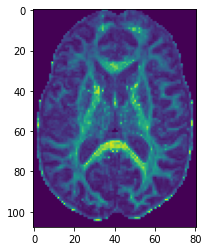

In [5]:
plt.imshow(GFA_axiale)

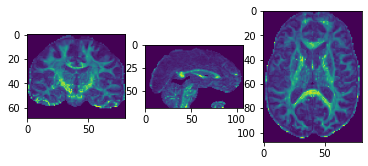

In [6]:
# Plot the GFA


%matplotlib inline

fig, ax = plt.subplots(1, 3)
ax[0].imshow(ndimage.rotate(GFA[:, GFA.shape[1]//2, :],90, reshape=True))
ax[1].imshow(ndimage.rotate(GFA[GFA.shape[0]//2, :, :],90, reshape=True))
ax[2].imshow(ndimage.rotate(GFA[:, :, GFA.shape[-1]//2], 90, reshape=True))

plt.show()

In [7]:
GFA_sagittale.shape

(69, 108)

In [8]:
data_small = maskdata[13:43, 44:74, 28:29]

from fury import window, actor

scene = window.Scene()

csaodfs = csamodel.fit(data_small).odf(sphere)
csaodfs = np.clip(csaodfs, 0, np.max(csaodfs, -1)[..., None])
csa_odfs_actor = actor.odf_slicer(csaodfs, sphere=sphere,
                                  scale=0.4)
csa_odfs_actor.display(z=0)

scene.add(csa_odfs_actor)

window.show(scene)

In [9]:

lut = actor.colormap_lookup_table(scale_range=(GFA.min(), GFA.max()*0.8),
                                  hue_range=(0.4, 1.),
                                  saturation_range=(1, 1.),
                                  value_range=(0., 1.))
GFA_actor = actor.slicer(GFA, affine, lookup_colormap=lut)

scene.clear()
scene.add(GFA_actor)

scene.reset_camera()
scene.zoom(1.4)
window.show(scene, size=(600, 600), reset_camera=False)


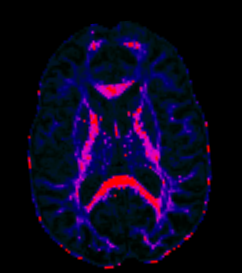

In [10]:
scene.clear()
slice_actor2 = GFA_actor.copy()

scene.add(slice_actor2)

slice_actor2.display(slice_actor2.shape[0]//2, None, None)
scene.zoom(1.4)
window.show(scene, size=(600, 600), reset_camera=False)

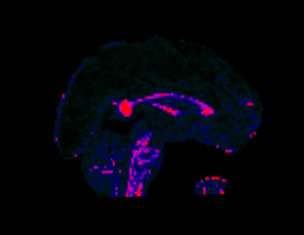


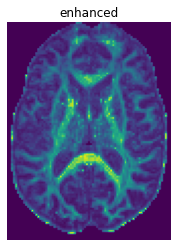

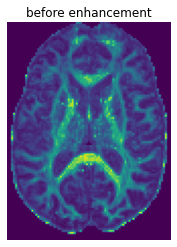

In [11]:
#to be reviewed after i don't see the difference between enhanced and not enhanced


def enhance_sharpness(image, strength):
    if len(image.shape) == 2:
        # Grayscale image
        gray_image = image
    else:
        # Convert the image to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Apply the unsharp mask filter
    sharpened_image = cv2.addWeighted(gray_image, 1 + strength, cv2.GaussianBlur(gray_image, (0, 0), strength), -strength, 0)

    # Convert the sharpened image back to RGB if necessary
    if len(image.shape) == 3:
        sharpened_image = cv2.cvtColor(sharpened_image, cv2.COLOR_GRAY2RGB)

    return sharpened_image

# Example usage
# Define the strength value for sharpness enhancement
strength = 100.0# Adjust this value to control the strength of the sharpness enhancement

# Enhance the sharpness of the image
sharpened_image = enhance_sharpness(GFA_axiale, strength)


# Display the sharpened image
plt.imshow(sharpened_image)
plt.axis('off')
plt.title('enhanced')
plt.show()

plt.imshow(GFA_axiale)
plt.axis('off')
plt.title('before enhancement')
plt.show()


In [12]:
def create_animation(ims):
    fig = plt.figure(figsize=(6, 6))
    plt.axis('off')
    im = plt.imshow(ims[0], cmap="gray")
    plt.close()

    def animate_func(i):
        im.set_array(ims[i])
        return im

    return animation.FuncAnimation(fig, animate_func, frames = len(ims), interval = 1000//24)

In [13]:

create_animation(GFA)

NameError: name 'animation' is not defined

c:\Users\Malek\AppData\Local\Programs\Python\Python39\lib\site-packages\persim\visuals.py:87: RuntimeWarning: overflow encountered in cast
  diagrams = [dgm.astype(np.float32, copy=True) for dgm in diagrams]


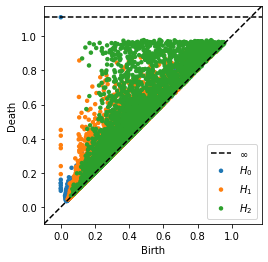

In [14]:
## compute persistence of the sublevel filtration of the volumetric image
pd = cripser.computePH(GFA,maxdim=2,location="birth")
pds = [pd[pd[:,0] == i] for i in range(3)]
diags = [p[:,1:3] for p in pds]
persim.plot_diagrams(diags)

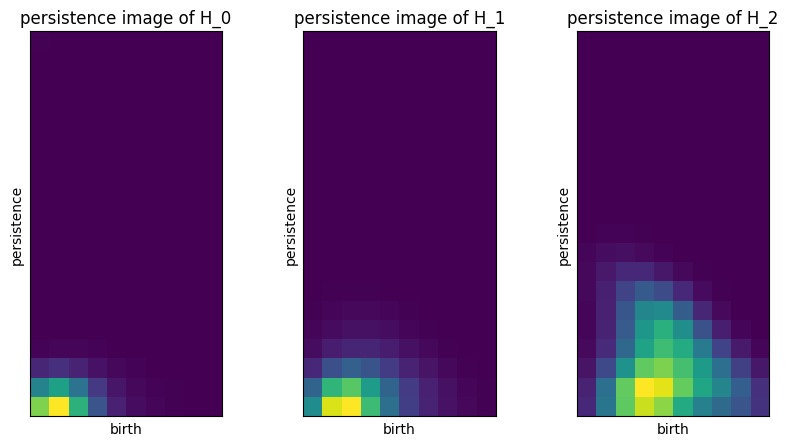

In [15]:
#Transforming H0,H1and H2 To persistance images 

min_birth, max_death = 0,2
dclip = [np.clip(d,min_birth, max_death) for d in diags]
pimgr = persim.PersistenceImager(pixel_size=0.1, kernel_params={'sigma': [[0.01, 0.0], [0.0, 0.01]]})
pimgr.fit(dclip, skew=True)
pimgs = pimgr.transform(dclip, skew=True,n_jobs=-1)

plt.figure(figsize=(10,5))
for i in range(3):
    ax = plt.subplot(1,3,i+1)
    pimgr.plot_image(pimgs[i], ax)
    plt.title("persistence image of H_{}".format(i))


c:\Users\Malek\AppData\Local\Programs\Python\Python39\lib\site-packages\persim\visuals.py:87: RuntimeWarning: overflow encountered in cast
  diagrams = [dgm.astype(np.float32, copy=True) for dgm in diagrams]


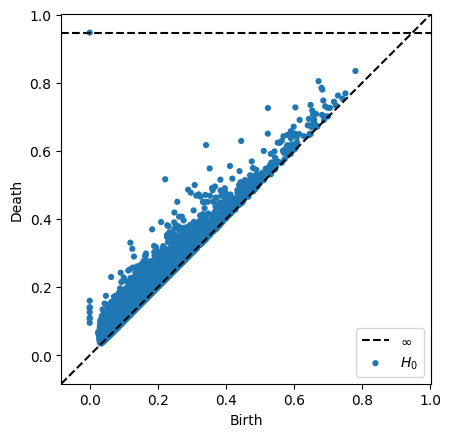

In [17]:
pd = cripser.computePH(GFA,maxdim=1,location="birth")
pds = [pd[pd[:,0] == i] for i in range(1)]
diags = [p[:,1:3] for p in pds]
persim.plot_diagrams(diags)

In [16]:
listsick = [
 'sub-RC4206',
 'sub-RC4215',
 'sub-RC4210',
 'sub-RC4213',
 'sub-RC4224',
 'sub-RC4219',
 'sub-RC4220',
 'sub-RC4226',
 'sub-RC4218',
 'sub-RC4225',
 'sub-RC4211',
 'sub-RC4221',
 'sub-RC4208',
 'sub-RC4227',
 'sub-RC4204',
 'sub-RC4201',
 'sub-RC4217',
 'sub-RC4207',
 'sub-RC4212',
 'sub-RC4214']
listhealthy = ['sub-RC4116',
 'sub-RC4122',
 'sub-RC4114',
 'sub-RC4113',
 'sub-RC4129',
 'sub-RC4110',
 'sub-RC4115',
 'sub-RC4131',
 'sub-RC4120',
 'sub-RC4117',
 'sub-RC4125',
 'sub-RC4118',
 'sub-RC4121',
 'sub-RC4109',
 'sub-RC4119',
 'sub-RC4128',
 'sub-RC4130',
 'sub-RC4126',
 'sub-RC4111',
 'sub-RC4107',
 'sub-RC4101',
 'sub-RC4123',
 'sub-RC4112'
 ]

c:\Users\Malek\AppData\Local\Programs\Python\Python39\lib\site-packages\persim\visuals.py:87: RuntimeWarning: overflow encountered in cast
  diagrams = [dgm.astype(np.float32, copy=True) for dgm in diagrams]
c:\Users\Malek\AppData\Local\Programs\Python\Python39\lib\site-packages\persim\visuals.py:87: RuntimeWarning: overflow encountered in cast
  diagrams = [dgm.astype(np.float32, copy=True) for dgm in diagrams]
c:\Users\Malek\AppData\Local\Programs\Python\Python39\lib\site-packages\persim\visuals.py:87: RuntimeWarning: overflow encountered in cast
  diagrams = [dgm.astype(np.float32, copy=True) for dgm in diagrams]
c:\Users\Malek\AppData\Local\Programs\Python\Python39\lib\site-packages\persim\visuals.py:87: RuntimeWarning: overflow encountered in cast
  diagrams = [dgm.astype(np.float32, copy=True) for dgm in diagrams]
c:\Users\Malek\AppData\Local\Programs\Python\Python39\lib\site-packages\persim\visuals.py:87: RuntimeWarning: overflow encountered in cast
  diagrams = [dgm.astype(np.f

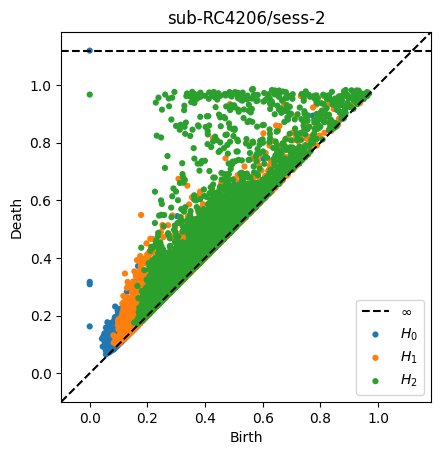

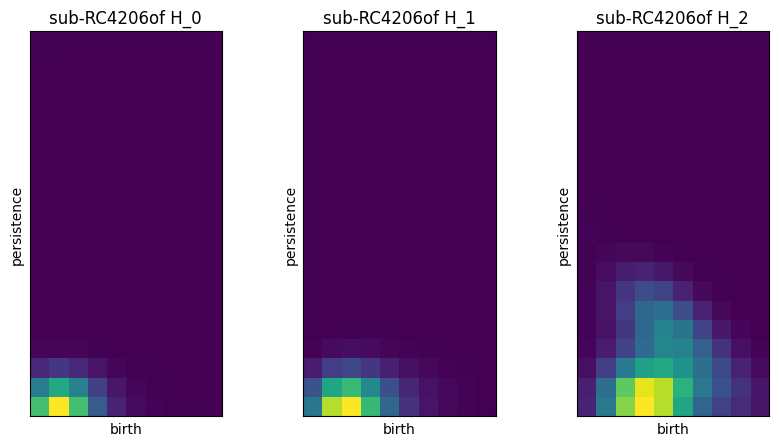

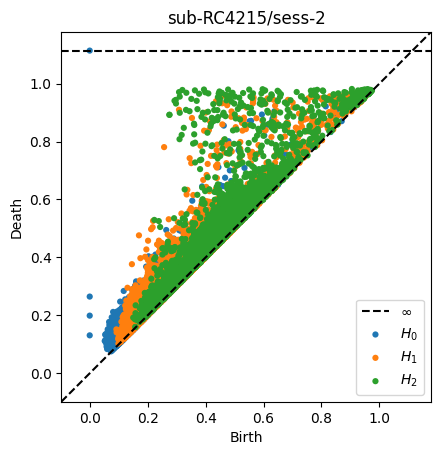

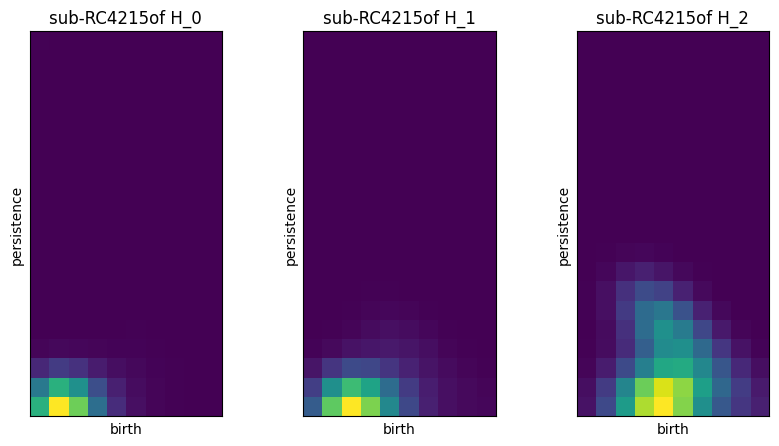

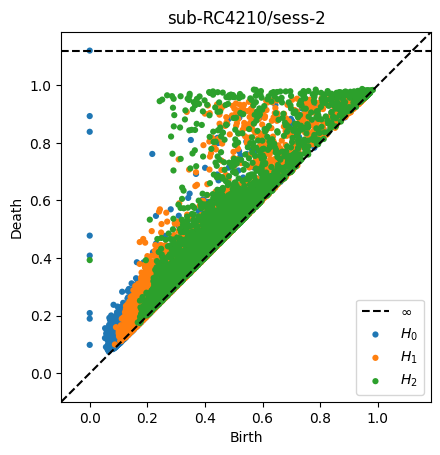

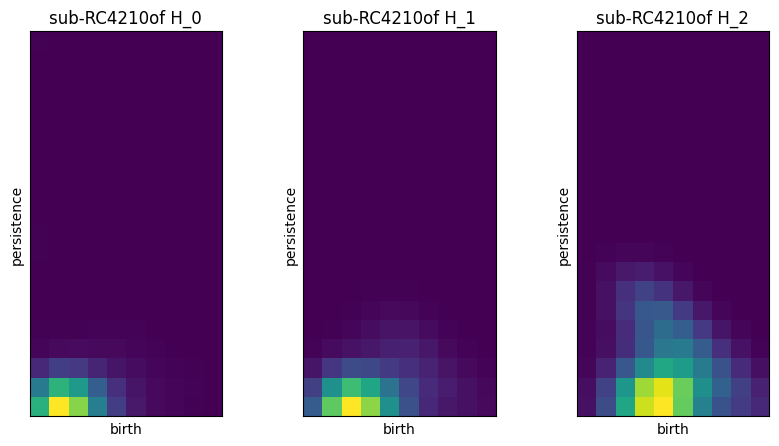

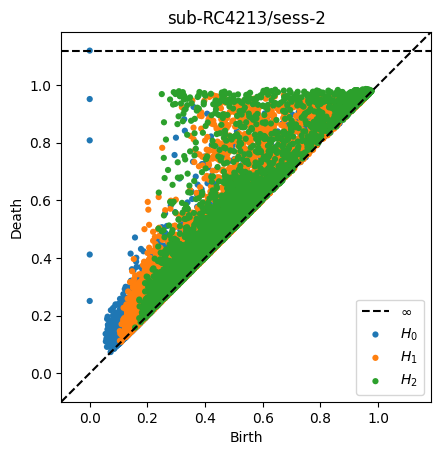

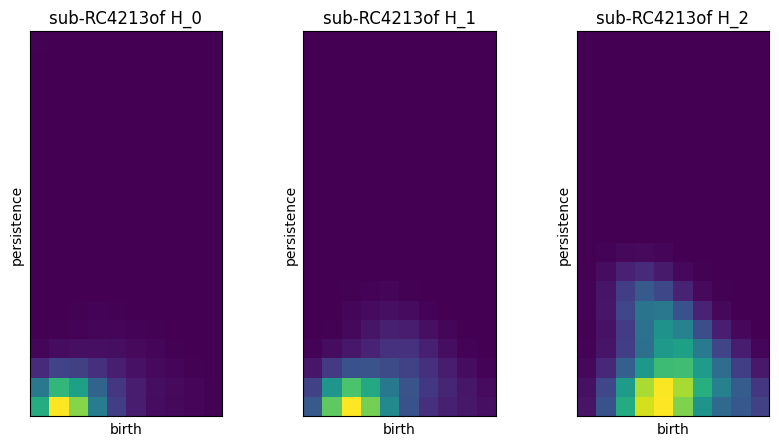

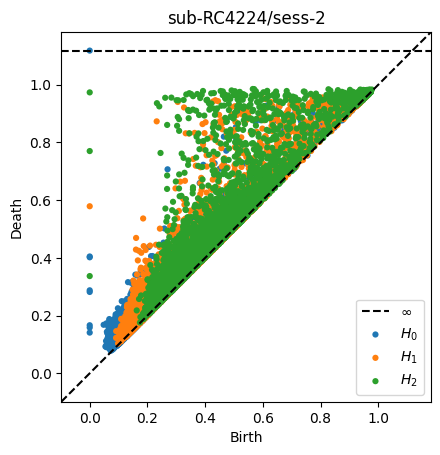

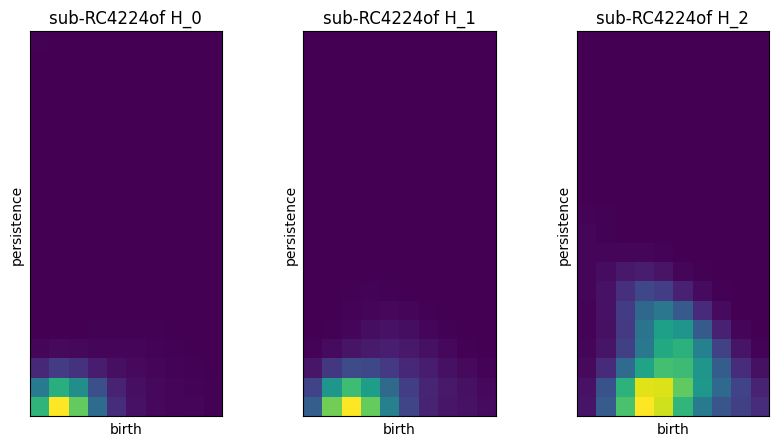

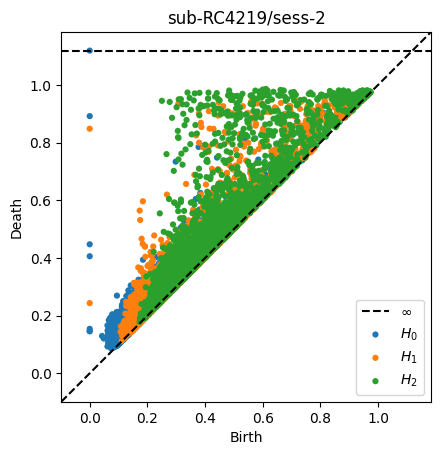

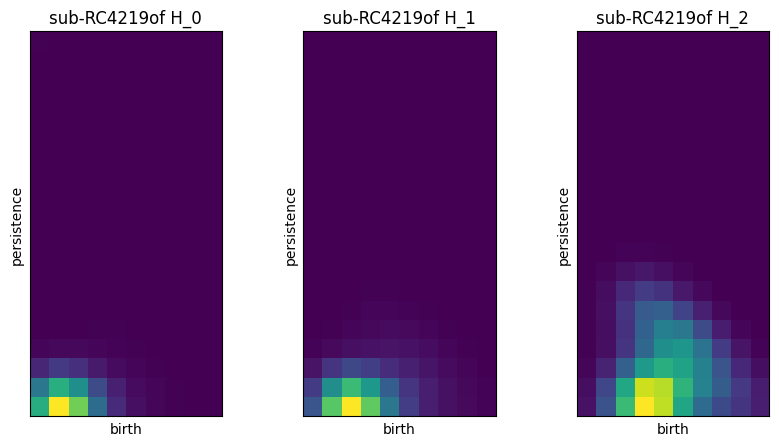

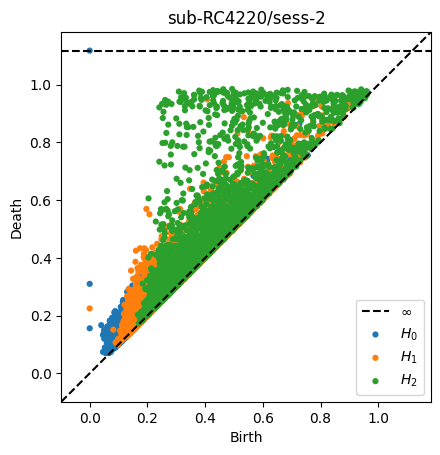

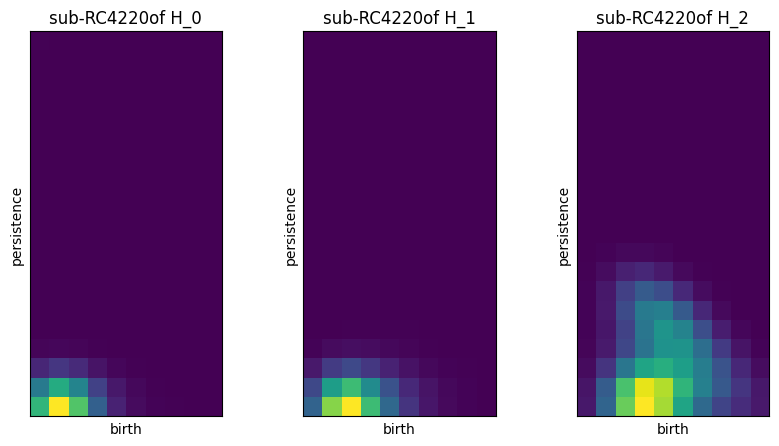

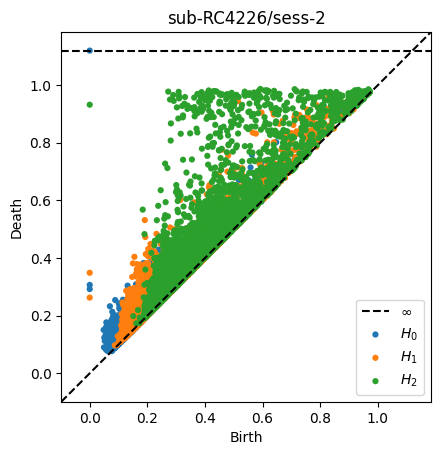

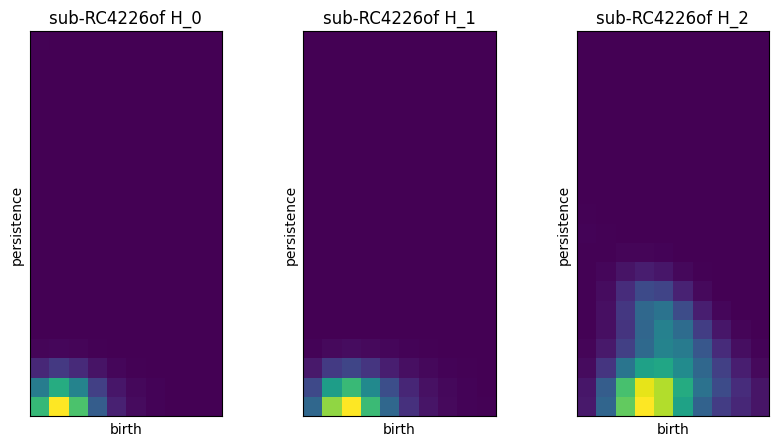

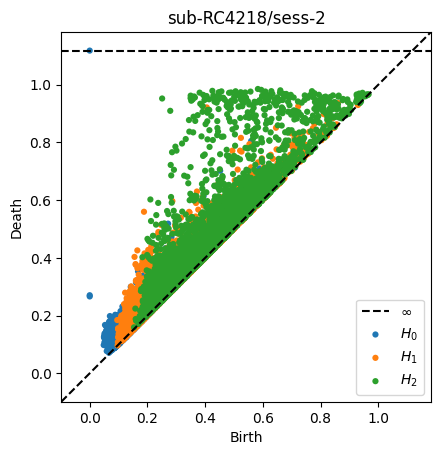

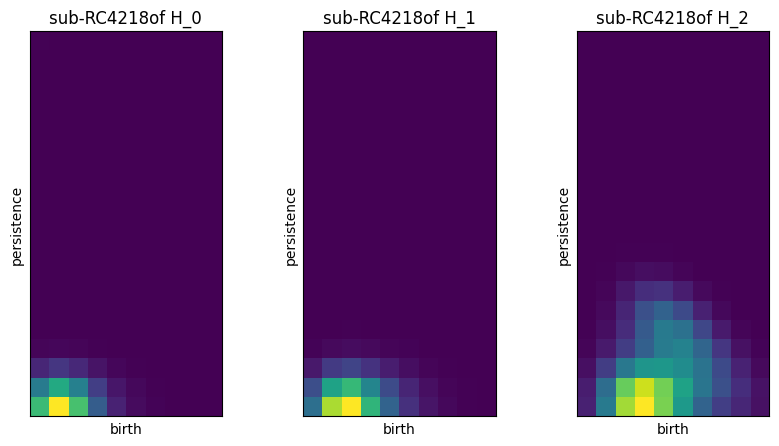

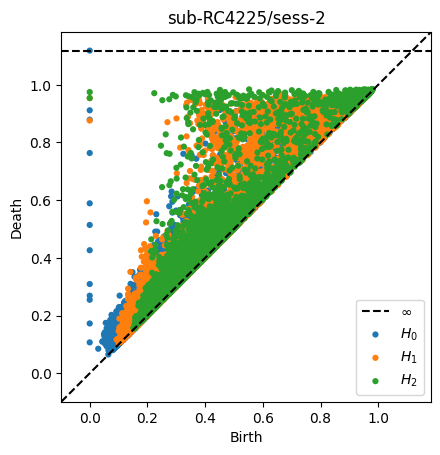

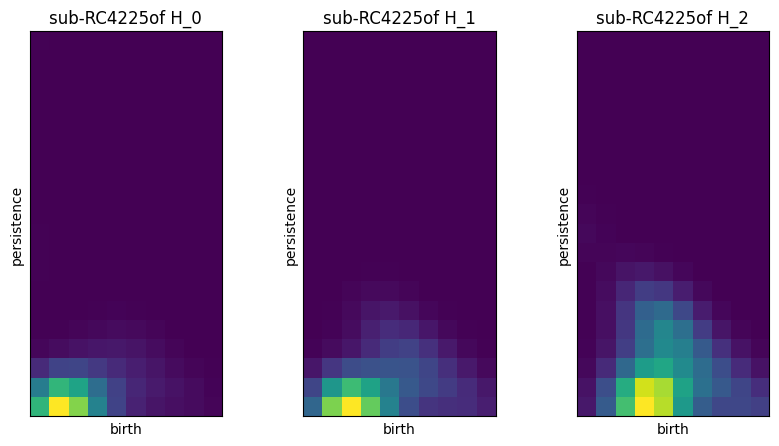

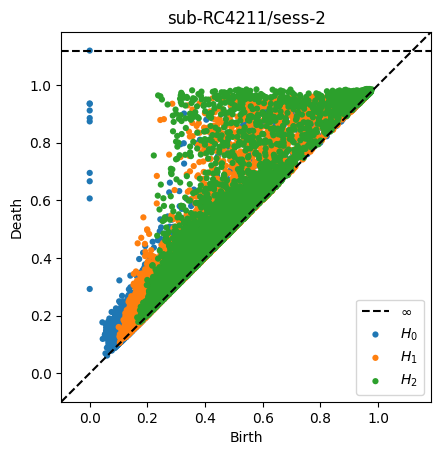

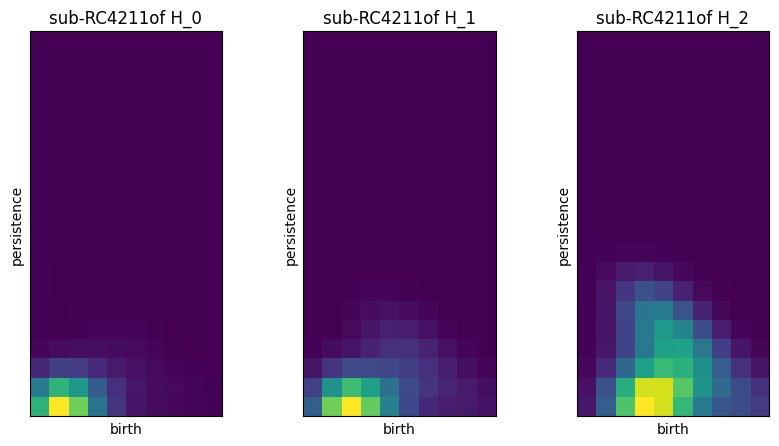

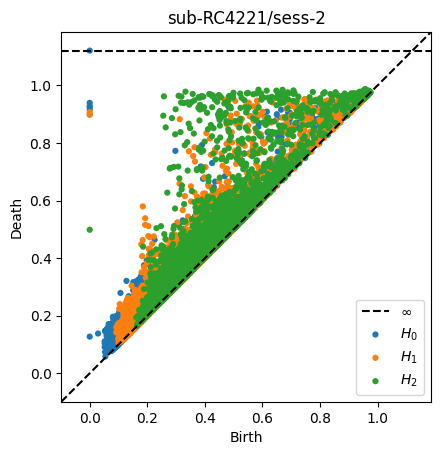

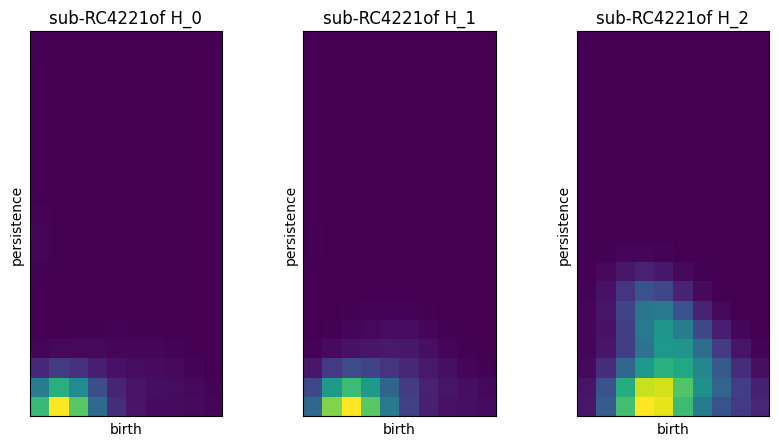

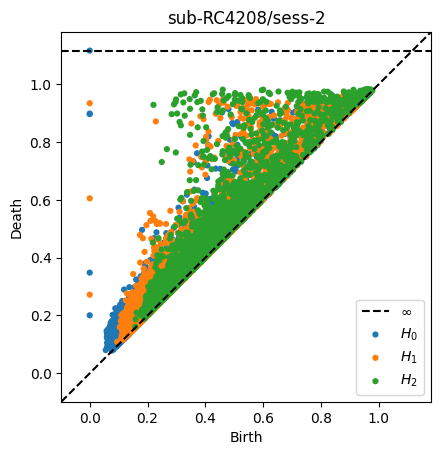

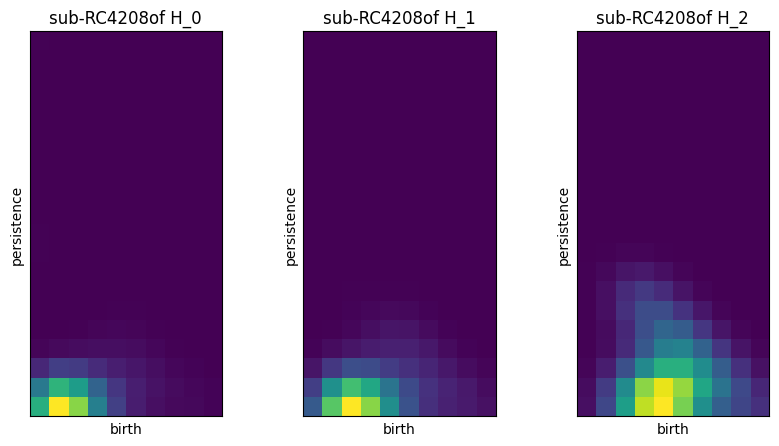

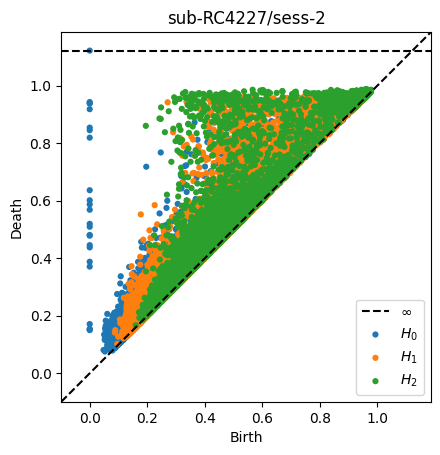

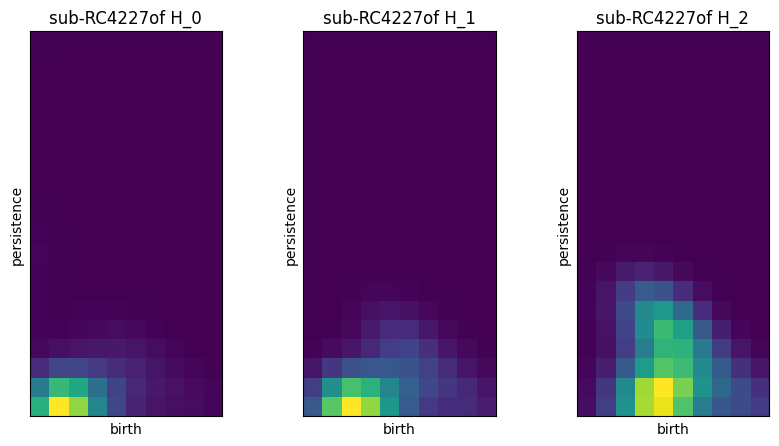

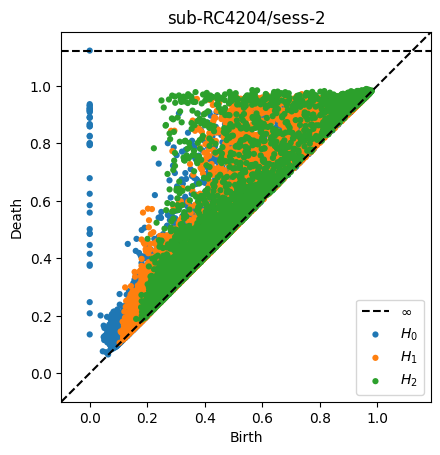

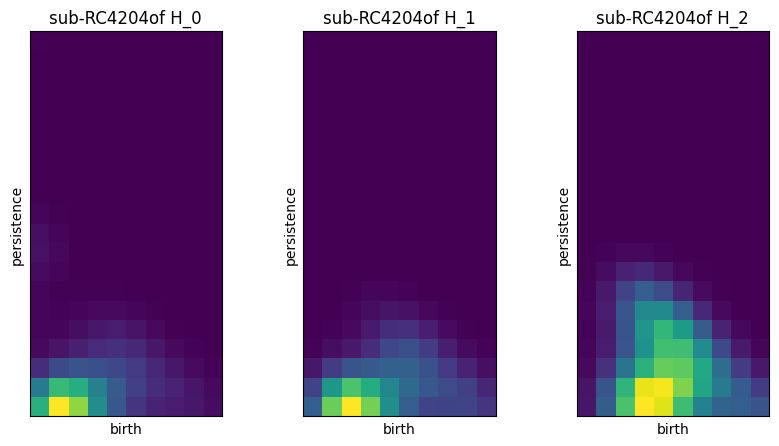

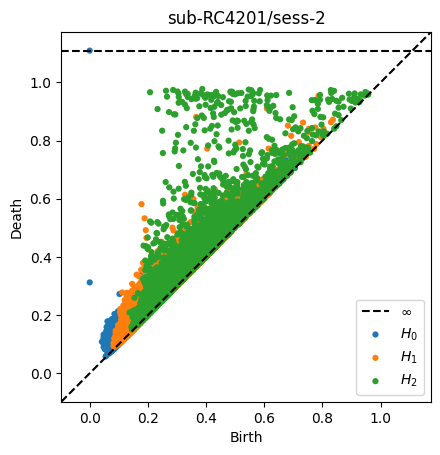

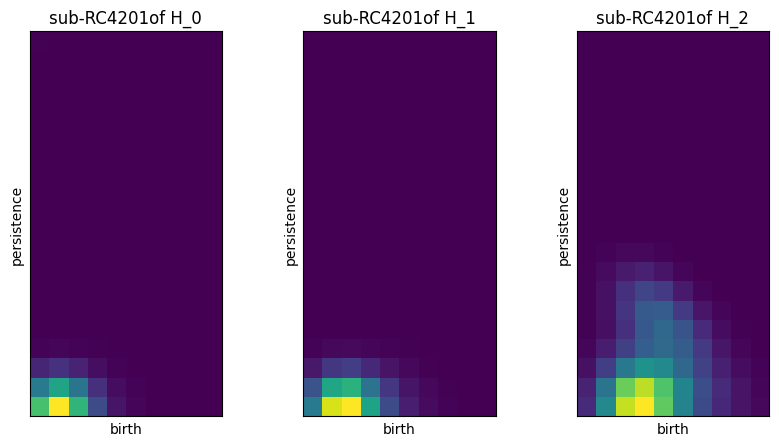

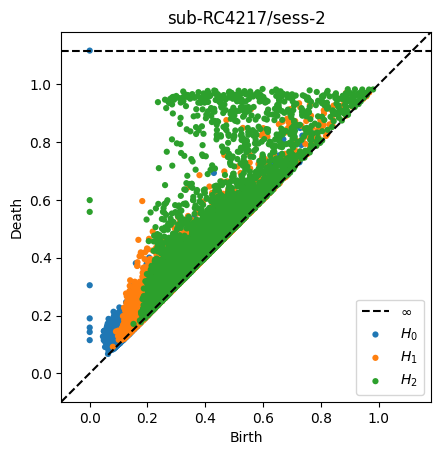

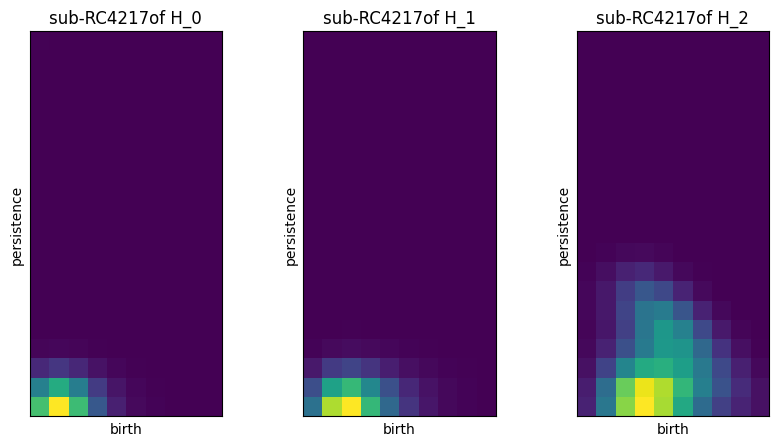

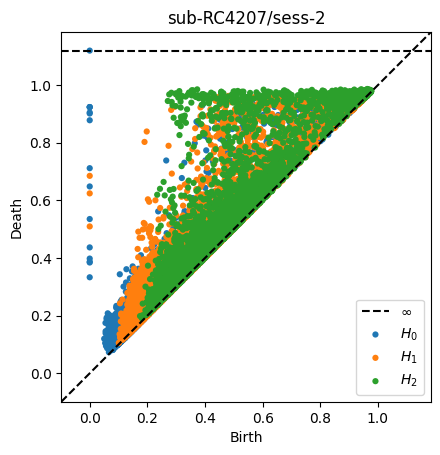

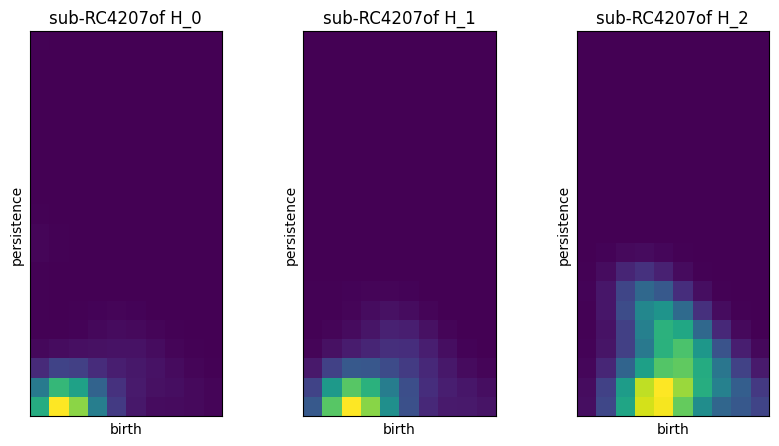

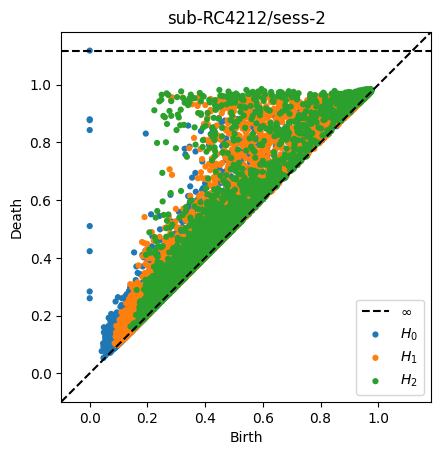

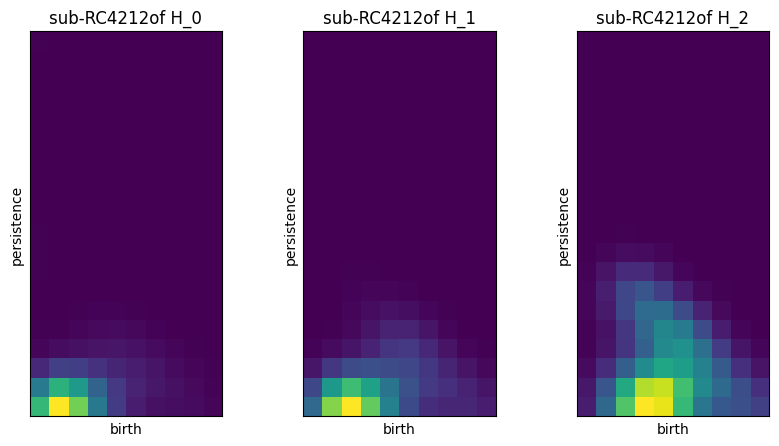

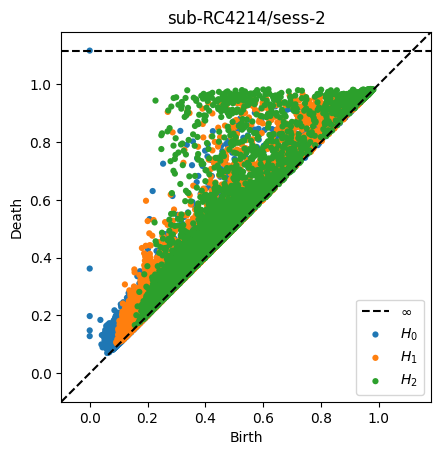

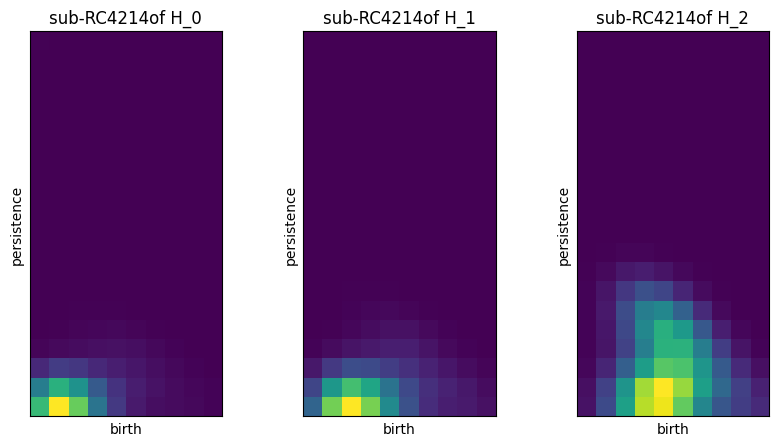

In [18]:
#GFA sick
import os 
import nibabel as nib
import numpy as np
from dipy.reconst.shm import CsaOdfModel
from dipy.data import get_fnames, default_sphere, get_sphere
# NEW
import matplotlib.pyplot as plt

from bids.layout import BIDSLayout

from dipy.io.gradients import read_bvals_bvecs
from dipy.core.gradients import gradient_table
import dipy.reconst.dti as dti
from dipy.segment.mask import median_otsu
from dipy.direction import peaks_from_model
import cripser
import persim

dwi_fname = []
bvec_fname = []
bval_fname =[]
dwi_img=[]
affine =[]
sick_diagram_array =[]
for subject in  listsick :
    subj = subject
    sess = '2'
    base_path = f"./openneuro/ds001907/{subj}/ses-{sess}/dwi/"
    dwi_fname.append(base_path+f"{subj}_ses-{sess}_dwi.nii.gz")
    bvec_fname.append(base_path+f"{subj}_ses-{sess}_dwi.bvec")
    bval_fname.append(base_path+f"{subj}_ses-{sess}_dwi.bval")
    dwi_img.append(nib.load(dwi_fname[-1]))
    affine.append(dwi_img[-1].affine)
    bvals, bvecs = read_bvals_bvecs(bval_fname[-1], bvec_fname[-1])
    gtab = gradient_table(bvals, bvecs)
    dwi_data = dwi_img[-1].get_fdata()
    dwi_data, dwi_mask = median_otsu(dwi_data, vol_idx=[0], numpass=1)  # Specify the volume index to the b0 volumes
    csamodel = CsaOdfModel(gtab, 4)
    csapeaks = peaks_from_model(model=csamodel,
                            data=dwi_data,
                            sphere=default_sphere,
                            relative_peak_threshold=.5,
                            min_separation_angle=25,
                            mask=dwi_mask,
                            return_odf=False,
                            normalize_peaks=True,
                            parallel=True)

    GFA = csapeaks.gfa
    pd = cripser.computePH(GFA,maxdim=2,location="birth")
    pds = [pd[pd[:,0] == i] for i in range(3)]
    

    figure, n_axis = plt.subplots()
    n_axis.set_title(subj+"/sess-"+sess)
    diags = [p[:,1:3] for p in pds]
    sick_diagram_array.append(diags)
    persim.plot_diagrams(diags, ax=n_axis)
    #tranform pesistance diags to images for each patient
    min_birth, max_death = 0,2
    dclip = [np.clip(d,min_birth, max_death) for d in diags]
    pimgr = persim.PersistenceImager(pixel_size=0.1, kernel_params={'sigma': [[0.01, 0.0], [0.0, 0.01]]})
    pimgr.fit(dclip, skew=True)
    pimgs = pimgr.transform(dclip, skew=True,n_jobs=-1)

    plt.figure(figsize=(10,5))
    for i in range(3):
        ax = plt.subplot(1,3,i+1)
        pimgr.plot_image(pimgs[i], ax)
        plt.title(subj+"of H_{}".format(i))

In [ ]:
print(sick_diagram_array)

[[array([[5.64064849e-002, 6.52607603e-002],
       [6.66255487e-002, 7.16693006e-002],
       [7.41419252e-002, 7.71580259e-002],
       ...,
       [8.68145731e-001, 8.79129072e-001],
       [7.74487554e-001, 8.93579360e-001],
       [0.00000000e+000, 1.79769313e+308]])], [array([[7.38508004e-002, 7.57184526e-002],
       [7.83421869e-002, 7.92577946e-002],
       [7.08936800e-002, 7.95380859e-002],
       ...,
       [9.20689781e-001, 9.40537561e-001],
       [8.32939235e-001, 9.41131589e-001],
       [0.00000000e+000, 1.79769313e+308]])], [array([[6.59983010e-002, 7.54113814e-002],
       [6.86708618e-002, 7.93758328e-002],
       [6.31930509e-002, 8.19913492e-002],
       ...,
       [9.39235834e-001, 9.51476429e-001],
       [9.46289996e-001, 9.51570299e-001],
       [0.00000000e+000, 1.79769313e+308]])], [array([[7.25430269e-002, 7.37817840e-002],
       [8.44496357e-002, 8.44953052e-002],
       [8.01990821e-002, 8.78037192e-002],
       ...,
       [9.51548979e-001, 9.51872910

c:\Users\Malek\AppData\Local\Programs\Python\Python39\lib\site-packages\persim\visuals.py:87: RuntimeWarning: overflow encountered in cast
  diagrams = [dgm.astype(np.float32, copy=True) for dgm in diagrams]
c:\Users\Malek\AppData\Local\Programs\Python\Python39\lib\site-packages\persim\visuals.py:87: RuntimeWarning: overflow encountered in cast
  diagrams = [dgm.astype(np.float32, copy=True) for dgm in diagrams]
c:\Users\Malek\AppData\Local\Programs\Python\Python39\lib\site-packages\persim\visuals.py:87: RuntimeWarning: overflow encountered in cast
  diagrams = [dgm.astype(np.float32, copy=True) for dgm in diagrams]
c:\Users\Malek\AppData\Local\Programs\Python\Python39\lib\site-packages\persim\visuals.py:87: RuntimeWarning: overflow encountered in cast
  diagrams = [dgm.astype(np.float32, copy=True) for dgm in diagrams]
c:\Users\Malek\AppData\Local\Programs\Python\Python39\lib\site-packages\persim\visuals.py:87: RuntimeWarning: overflow encountered in cast
  diagrams = [dgm.astype(np.f

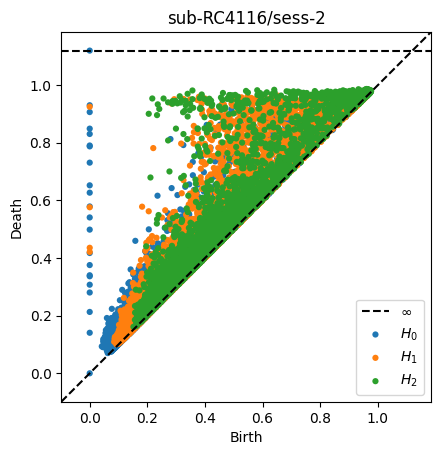

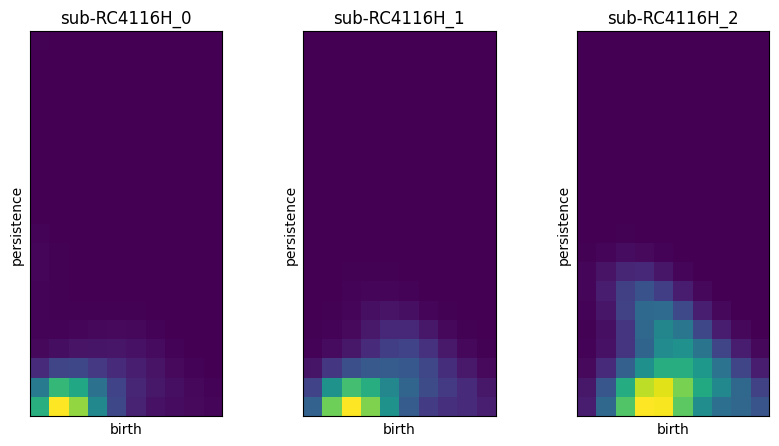

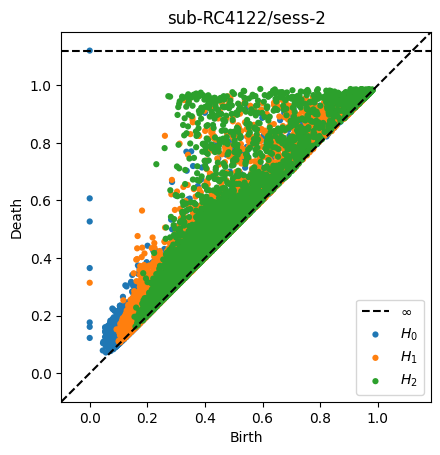

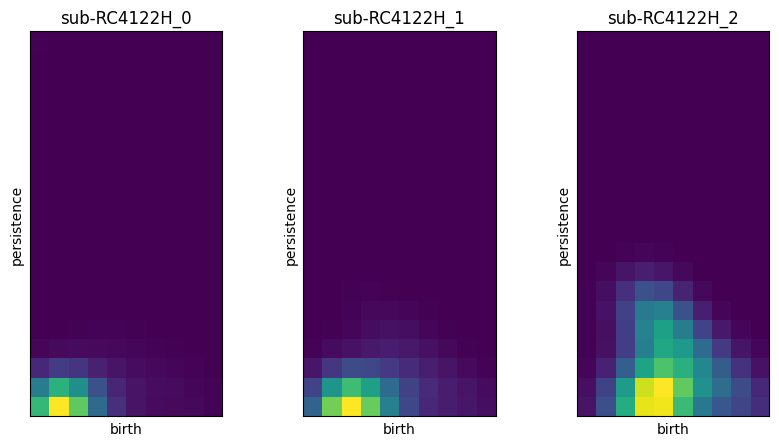

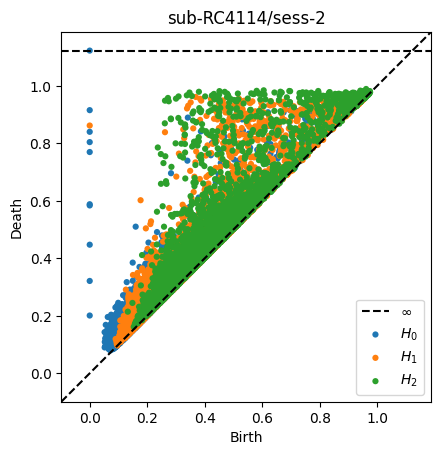

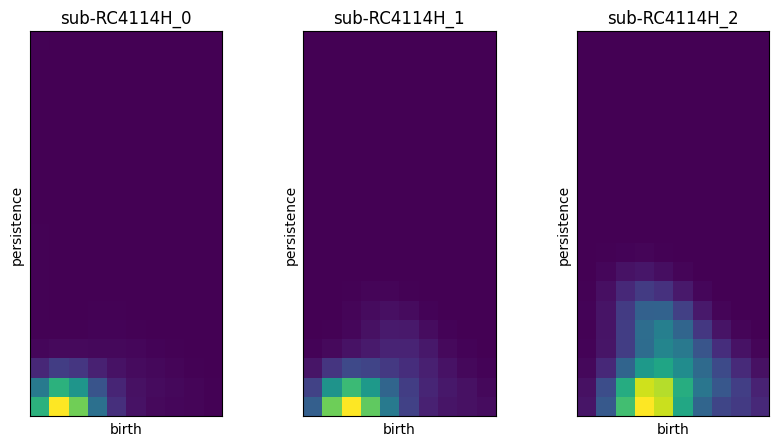

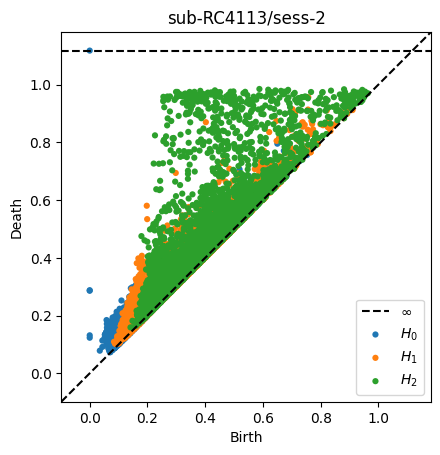

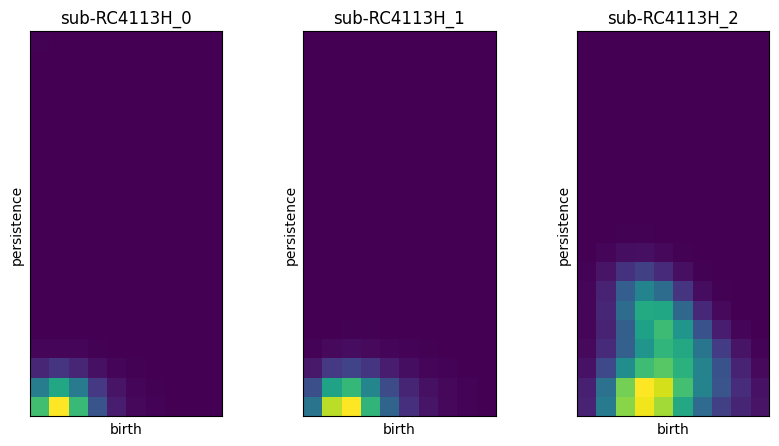

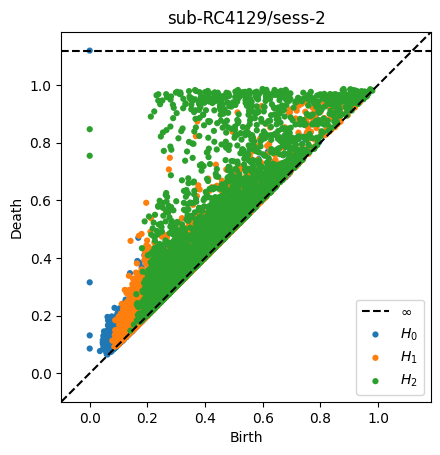

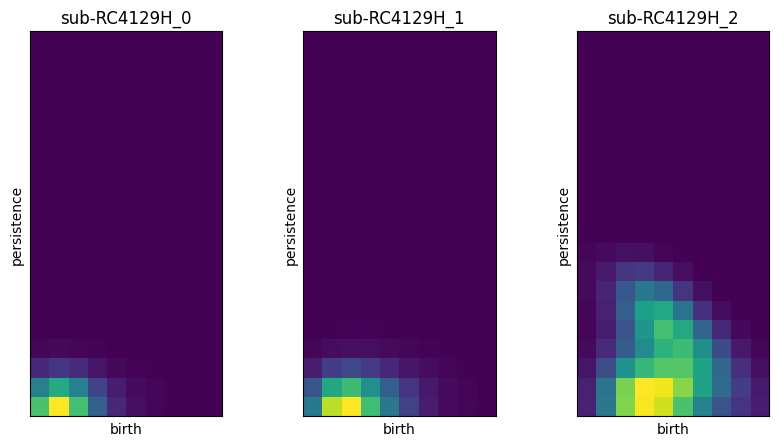

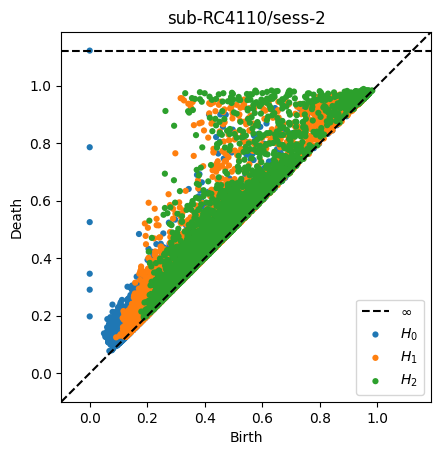

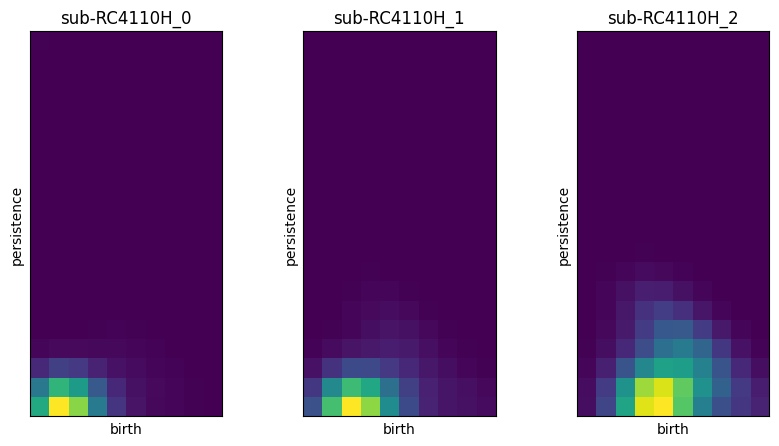

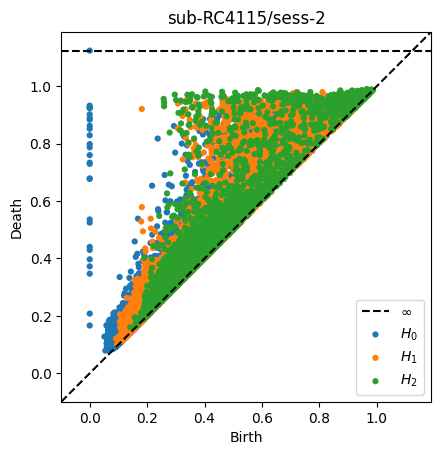

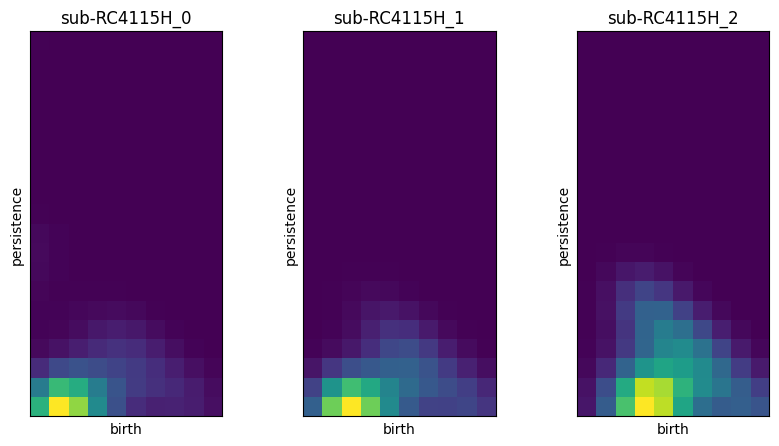

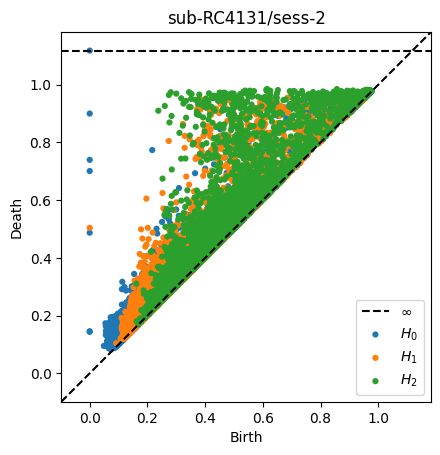

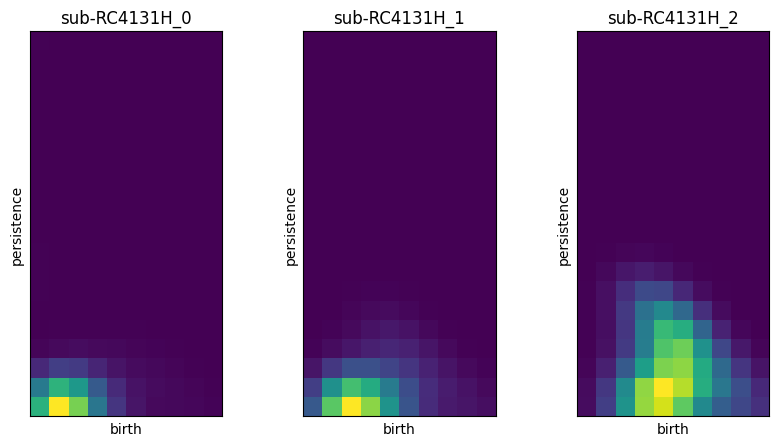

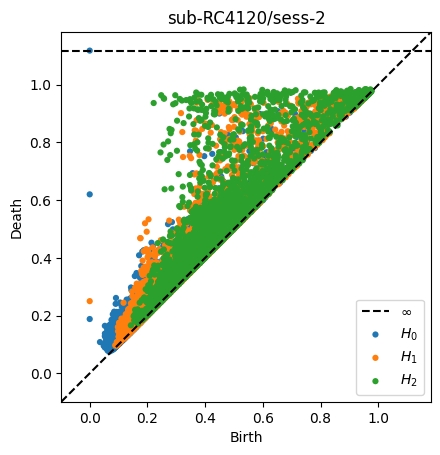

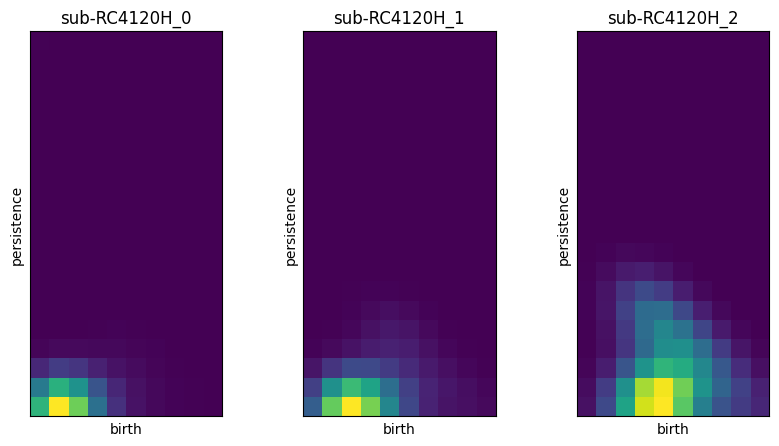

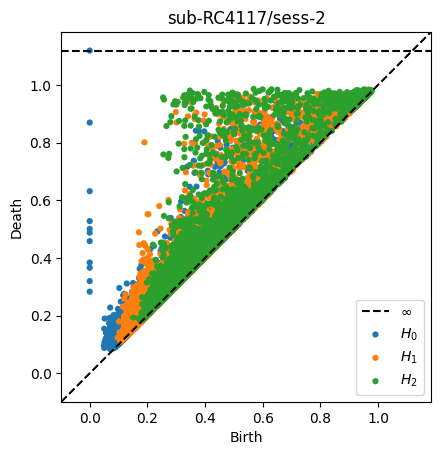

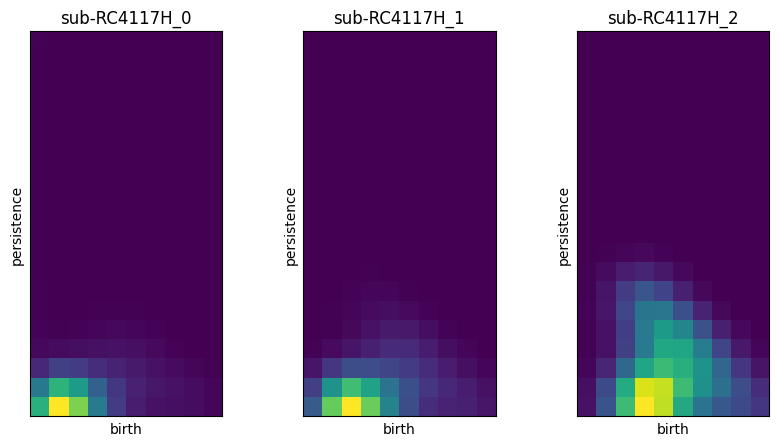

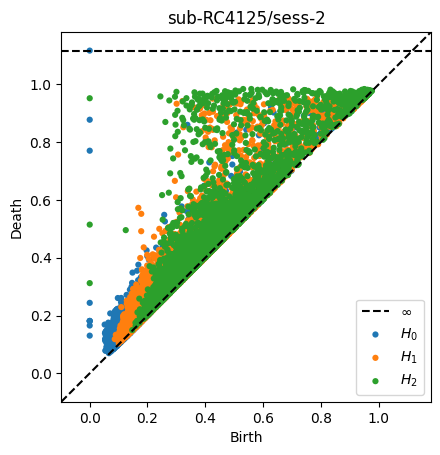

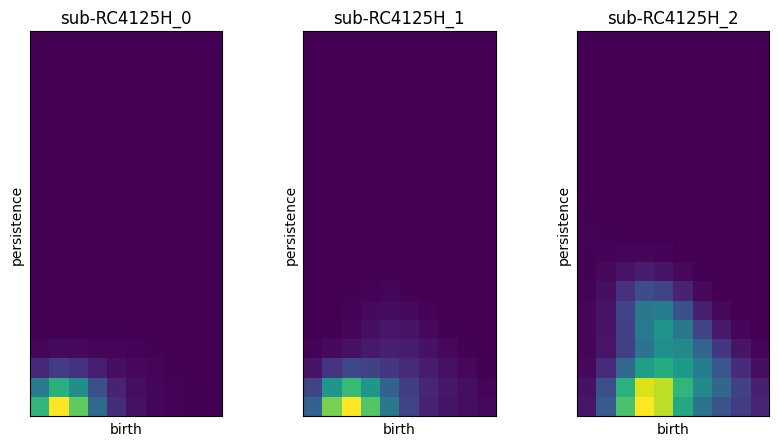

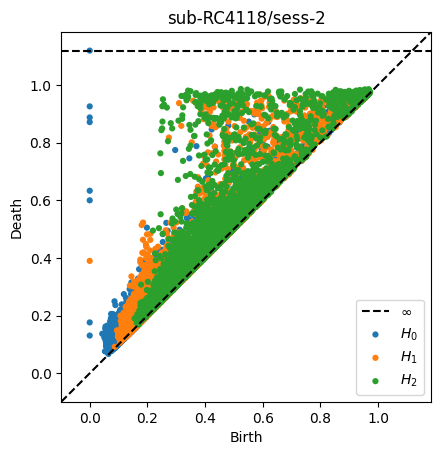

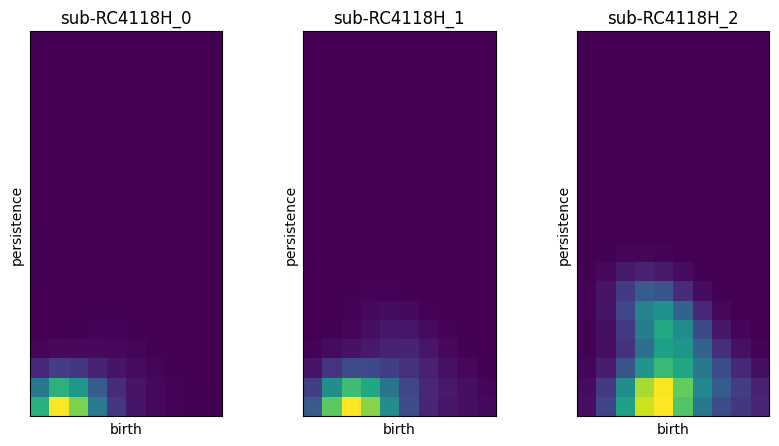

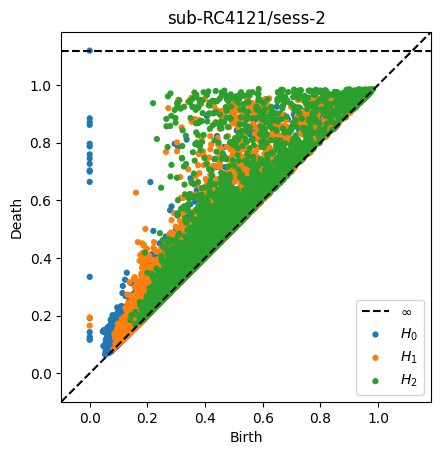

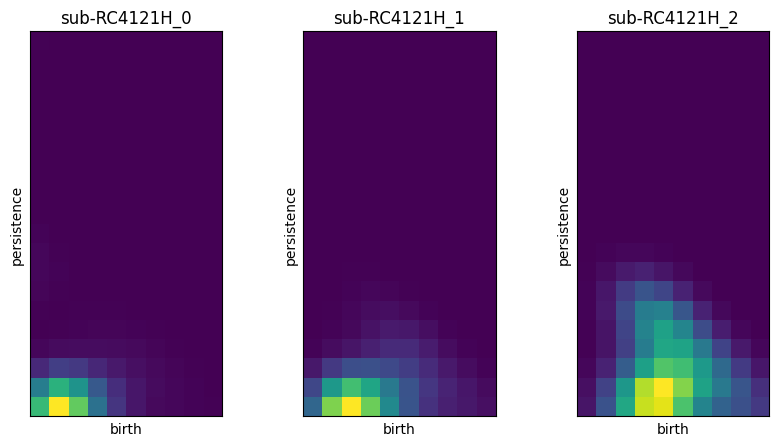

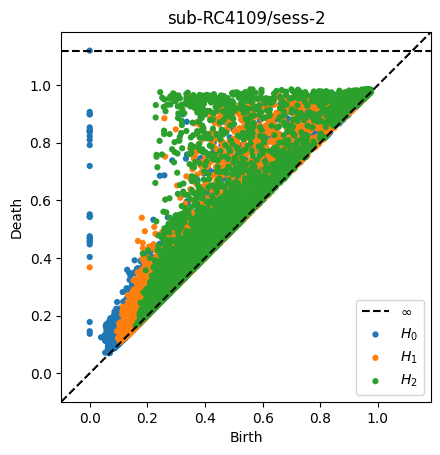

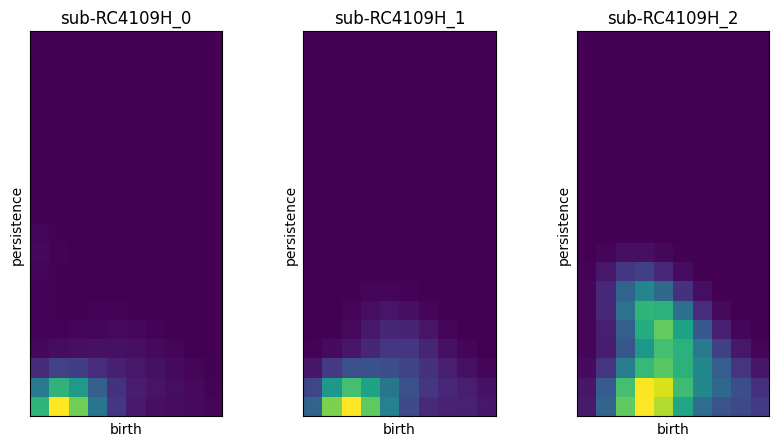

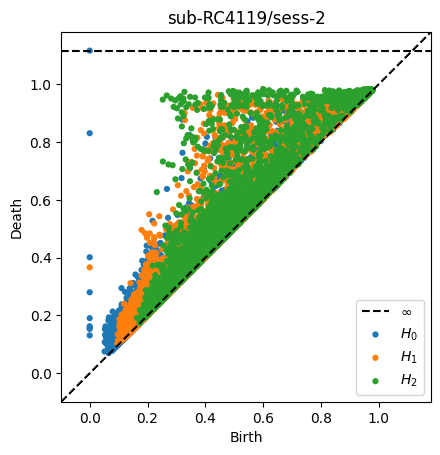

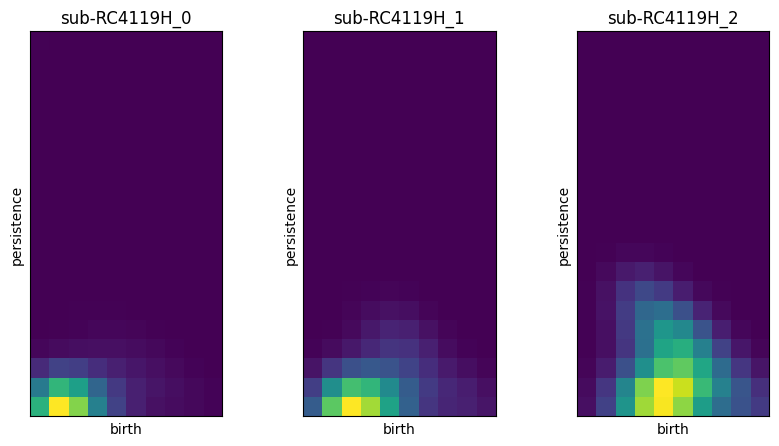

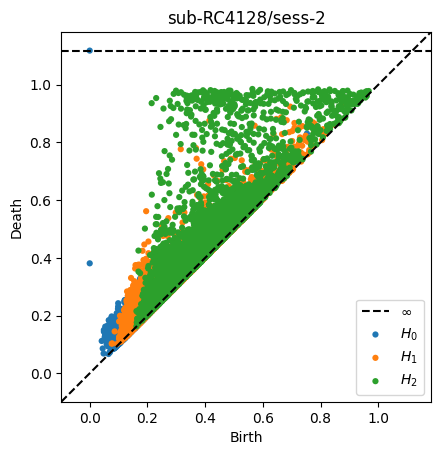

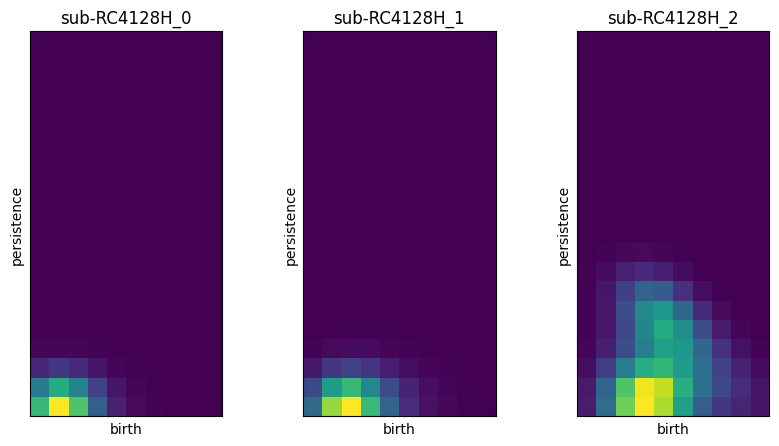

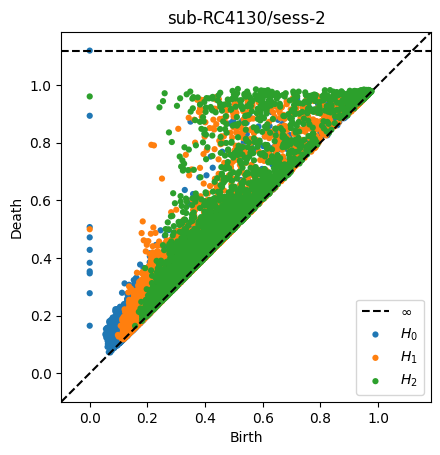

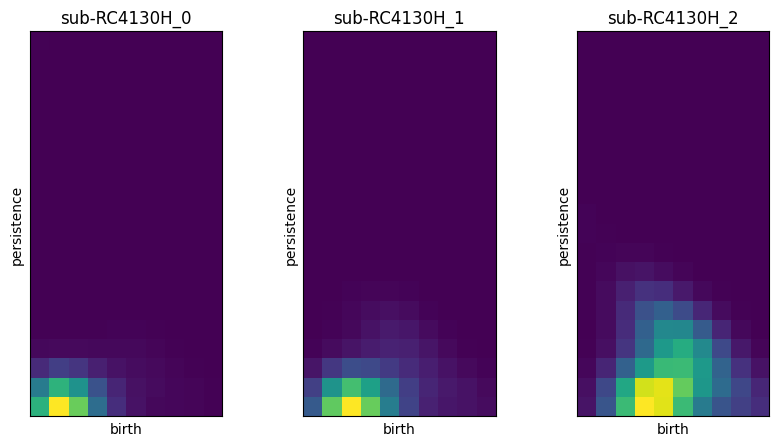

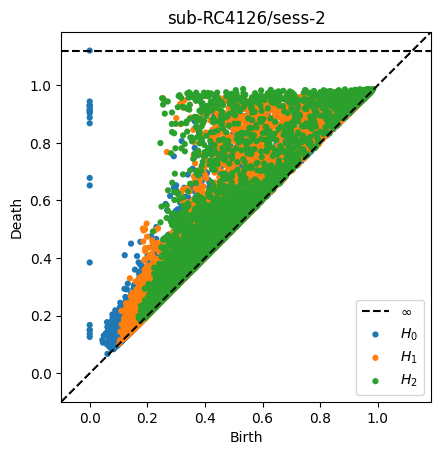

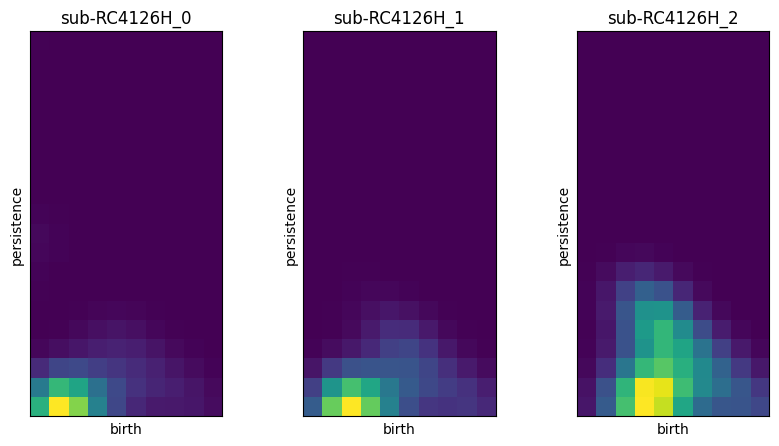

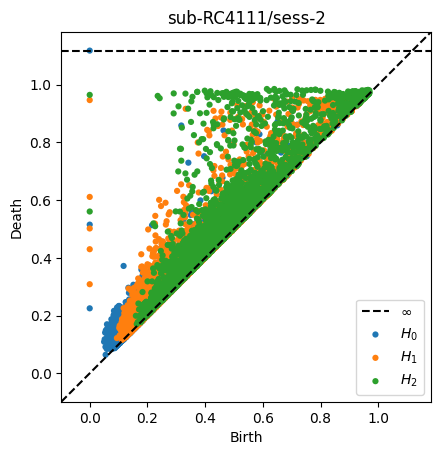

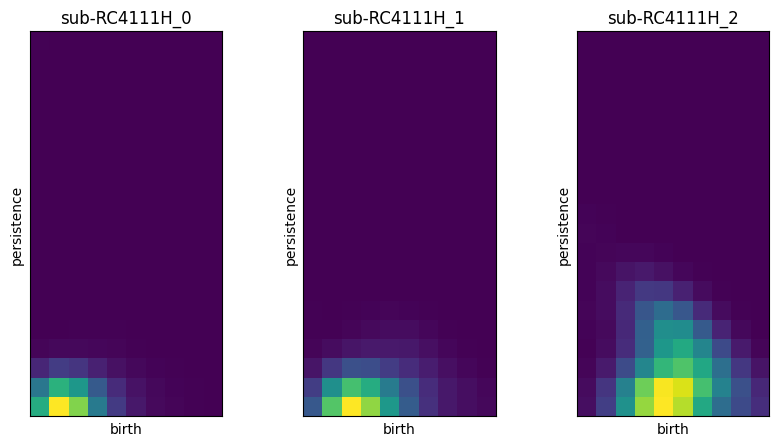

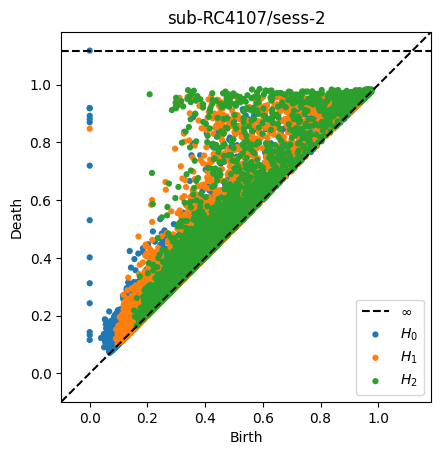

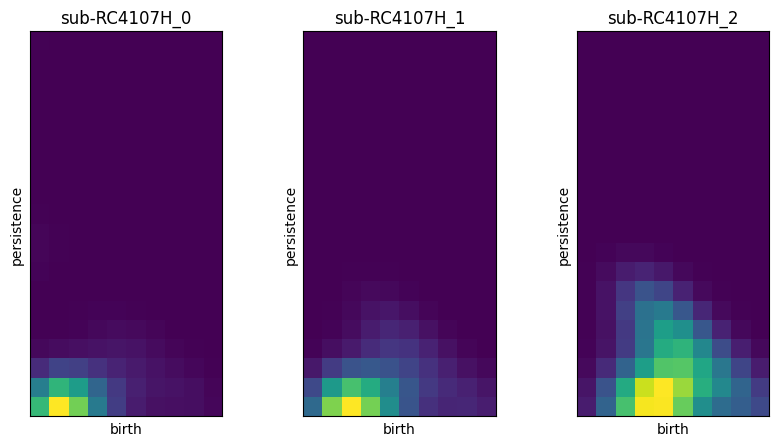

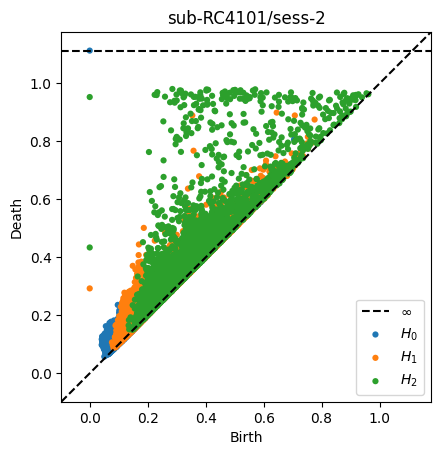

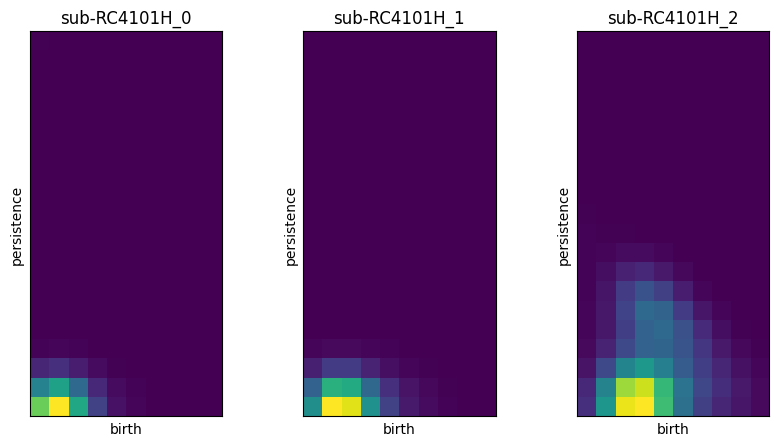

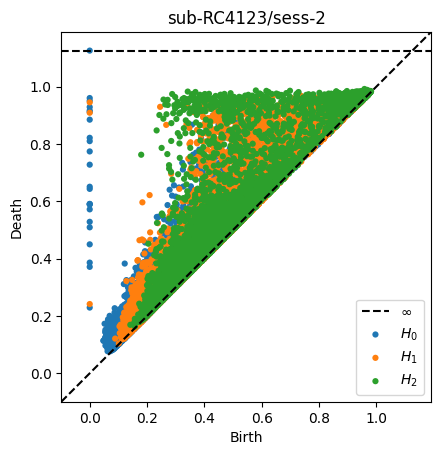

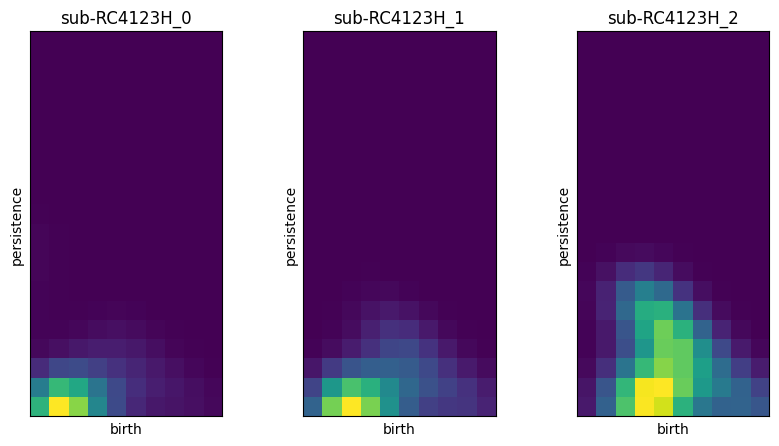

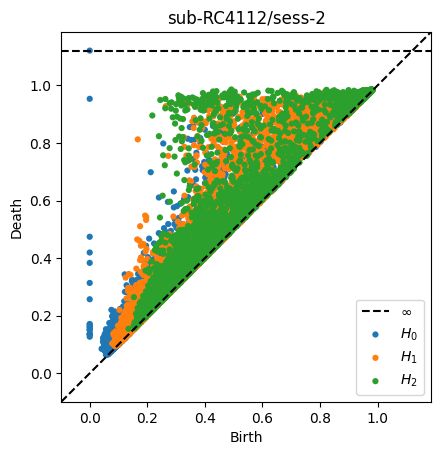

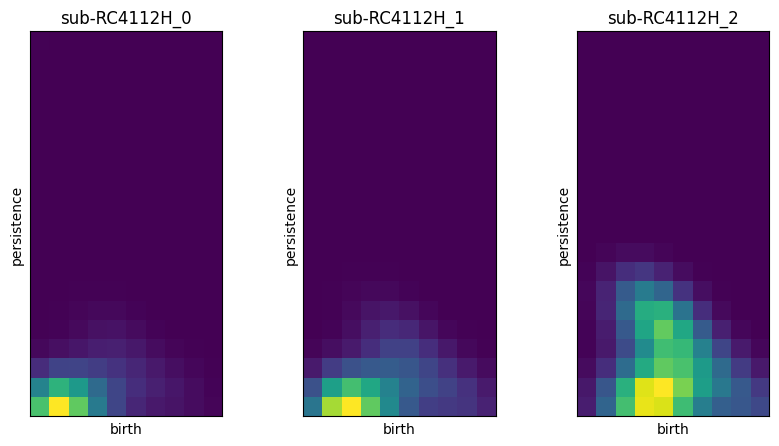

In [ ]:
# GFA healthy
import os 
import nibabel as nib
import numpy as np
from dipy.reconst.shm import CsaOdfModel
from dipy.data import get_fnames, default_sphere, get_sphere
# NEW
import matplotlib.pyplot as plt

from bids.layout import BIDSLayout

from dipy.io.gradients import read_bvals_bvecs
from dipy.core.gradients import gradient_table
import dipy.reconst.dti as dti
from dipy.segment.mask import median_otsu
from dipy.direction import peaks_from_model
import cripser
import persim

dwi_fname = []
bvec_fname = []
bval_fname =[]
dwi_img=[]
affine =[]
healthy_diagram_array =[]
for subject in  listhealthy :
    subj = subject
    sess = '2'
    base_path = f"./openneuro/ds001907/{subj}/ses-{sess}/dwi/"
    dwi_fname.append(base_path+f"{subj}_ses-{sess}_dwi.nii.gz")
    bvec_fname.append(base_path+f"{subj}_ses-{sess}_dwi.bvec")
    bval_fname.append(base_path+f"{subj}_ses-{sess}_dwi.bval")
    dwi_img.append(nib.load(dwi_fname[-1]))
    affine.append(dwi_img[-1].affine)
    bvals, bvecs = read_bvals_bvecs(bval_fname[-1], bvec_fname[-1])
    gtab = gradient_table(bvals, bvecs)
    dwi_data = dwi_img[-1].get_fdata()
    dwi_data, dwi_mask = median_otsu(dwi_data, vol_idx=[0], numpass=1)  # Specify the volume index to the b0 volumes
    csamodel = CsaOdfModel(gtab, 4)
    csapeaks = peaks_from_model(model=csamodel,
                            data=dwi_data,
                            sphere=default_sphere,
                            relative_peak_threshold=.5,
                            min_separation_angle=25,
                            mask=dwi_mask,
                            return_odf=False,
                            normalize_peaks=True,
                            parallel= True)

    GFA = csapeaks.gfa
    pd = cripser.computePH(GFA,maxdim=2,location="birth")
    pds = [pd[pd[:,0] == i] for i in range(3)]
    # Changed!

    figure, n_axis = plt.subplots()
    n_axis.set_title(subj+"/sess-"+sess)
    diags = [p[:,1:3] for p in pds]
    healthy_diagram_array.append(diags)
    persim.plot_diagrams(diags,ax=n_axis)
    #tranform pesistance diags to images for each patient
    min_birth, max_death = 0,2
    dclip = [np.clip(d,min_birth, max_death) for d in diags]
    pimgr = persim.PersistenceImager(pixel_size=0.1, kernel_params={'sigma': [[0.01, 0.0], [0.0, 0.01]]})
    pimgr.fit(dclip, skew=True)
    pimgs = pimgr.transform(dclip, skew=True,n_jobs=-1)

    plt.figure(figsize=(10,5))
    for i in range(3):
        ax = plt.subplot(1,3,i+1)
        pimgr.plot_image(pimgs[i], ax)
        plt.title(subj+"H_{}".format(i))
    

list